# Machine Learning 2 - Semester Project
# Garbage Classification

<div class="alert alert-block alert-info">
<b>Tip:</b> Revised Order:

1. **Data Collection:**
   - Collect a dataset of images representing different types of garbage items (plastic, paper, glass, etc.).
   - Found multiple data sets on kaggle
    
2. **Image Classification:**
   - Use convolutional neural networks (CNNs) to build an image classification model.
   - Train the model to recognize and classify each type of garbage item.
   - Evaluate the model's performance using appropriate metrics.

3. **Pre-trained Models Comparison:**
   - Choose popular pre-trained models for image classification (e.g., ResNet, VGG, MobileNet).
   - Fine-tune these models on your garbage classification dataset.
   - Evaluate the performance of the fine-tuned models.
   - Compare the performance metrics with your custom-trained model.

4. **Clustering and Dimension Reduction:**
   - Apply clustering algorithms (e.g., K-Means) to group similar garbage items together.
        - (Hope to find clusters like: recycleable/ bio/ others
   - Use dimension reduction techniques (e.g., PCA) to visualize and analyze the features of the garbage items.

5. **Integrating Recommendations:**
   - Implement a recommendation system that suggests the appropriate recycling bin for a given item.
        - maybe simple tree??
   - Use knowledge from the clustering and dimension reduction to enhance recommendation accuracy.


</div>

<div class="alert alert-block alert-info">
<b>Training Metrics Explanation:</b>

- **loss:**
  - The training loss at the end of the epoch. It represents the average value of the loss function across all training samples.

- **accuracy:**
  - The training accuracy at the end of the epoch. It represents the proportion of correctly classified training samples.

- **val_loss:**
  - The validation loss at the end of the epoch. It represents the average value of the loss function across all validation samples.
  
  Categorical Crossentropy Loss Formula:
  
  
  Categorical Crossentropy Loss =$ - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{i,j} \cdot \log(\hat{y}_{i,j})$

  Where:
    - $N$ is the number of samples in the batch.
    - $C$ is the number of classes.
    - $y_{i,j}$ is 1 if the true class of sample \(i\) is \(j\), 0 otherwise.
    - $(\hat{y}_{i,j})$ is the predicted probability that sample \(i\) belongs to class \(j\).

- **val_accuracy:**
  - The validation accuracy at the end of the epoch. It represents the proportion of correctly classified validation samples.
</div>


***
# Project Setup

## Problem Setting

-hi 

### Vorgehen/ Project Plan
* generalisation of the model -> do not overfit

* what is the best architecture for CNN???

### Models

### Evaluation Protocoll

### Model comparision

## Library Setup

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

#!pip install ann_visualizer
# Libraries for Images
import os
import json
import glob
from PIL import Image

# Libraries for Evaluations and Train/Test Split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
#!pip install keras-tuner
#import keras_turner
from keras_tuner.tuners import BayesianOptimization

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

#VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


#ResNET
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

#Statistical Test
from scipy.stats import ttest_rel
from sklearn.metrics import accuracy_score
from scipy.stats import binom

#Evaluation
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#Model Visualization
from ann_visualizer.visualize import ann_viz
from tensorflow.keras.utils import plot_model


#Others
from tqdm import tqdm  # Optional: tqdm for progress bar
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from itertools import combinations

from tensorflow.keras.models import clone_model
from tensorflow.keras.models import load_model

#Own functions
import sys
from Own_Functions.k_fold_utils import k_fold_cross_validation
from Own_Functions.compare_models import compare_models
from Own_Functions.compare_model_performance import compare_model_performance
from Own_Functions.check_compile import check_compile
from Own_Functions.count_images_in_subfolders import count_images_in_subfolders
from Own_Functions.evaluate_model import evaluate_model
from Own_Functions.save_results_to_json import save_results_to_json
from Own_Functions.save_history_to_json import save_history_to_json
from Own_Functions.subgenerator_utils import create_subgenerator 
from Own_Functions.plot_metric_across_folds import plot_metric_across_folds 
from Own_Functions.plot_comparison_across_folds import plot_comparison_across_folds 
from Own_Functions.load_results_from_json import load_results_from_json
from Own_Functions.compare_models_extended import compare_models 
from Own_Functions.perform_and_compare_t_test import perform_and_compare_t_test 
from Own_Functions.sign_test import sign_test 
from Own_Functions.sign_test_table import sign_test_table 
from Own_Functions.k_fold_parallel_utils import k_fold_cross_validation_parallel



## Data and Image Exploration

In [2]:
# Example usage:
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification/'
image_overview = count_images_in_subfolders(root_folder_path)

image_overview

,Classes,Number_Images
0,paper,1050
1,green-glass,629
2,clothes,5325
3,metal,769
4,cardboard,891
5,trash,697
6,biological,985
7,white-glass,775
8,battery,945
9,brown-glass,607


In [3]:
image_overview['Number_Images'].sum()

15515

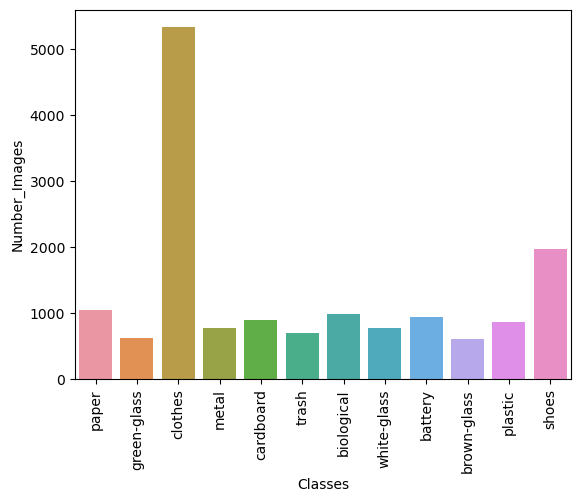

In [4]:
sns.barplot(image_overview, x="Classes", y="Number_Images")
plt.xticks(rotation=90)
plt.show()

## Data/ Image Loading and Data Augmentation

In [6]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pfad zum Hauptverzeichnis der Daten
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'

# Liste zum Speichern der Dateipfade und Labels
file_paths = []
labels = []

# Angenommen, jedes Unterverzeichnis im Root-Verzeichnis entspricht einer Klasse
for class_name in os.listdir(root_folder_path):
    class_dir = os.path.join(root_folder_path, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_name, file_name))  # Speichere relativen Pfad
            labels.append(class_name)

# Konvertiere Listen in Arrays für die Verarbeitung
file_paths = np.array(file_paths)
labels = np.array(labels)

# Aufteilung der Daten in Training+Validierung und Test, stratifizierte Aufteilung
file_paths_train_val, file_paths_test, labels_train_val, labels_test = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# Aufteilung der Trainings- und Validierungsdaten, stratifizierte Aufteilung
file_paths_train, file_paths_val, labels_train, labels_val = train_test_split(
    file_paths_train_val, labels_train_val, test_size=0.25, random_state=42, stratify=labels_train_val)


# Initialisiere ImageDataGenerator-Instanzen für Training und Validierung/Test ohne Augmentierung
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Da wir die Dateipfade und Labels direkt haben, könnten wir hier flow_from_dataframe oder eine ähnliche Methode benötigen
# Dies erfordert, dass du ein DataFrame aus den Pfaden und Labels erstellst

# Erstelle DataFrames
df_train = pd.DataFrame({'filepath': file_paths_train, 'label': labels_train})
df_val = pd.DataFrame({'filepath': file_paths_val, 'label': labels_val})
df_test = pd.DataFrame({'filepath': file_paths_test, 'label': labels_test})

# Initialisiere ImageDataGenerator für Training mit Augmentierung
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Rescale pixel values to be between 0 and 1
    shear_range=0.2,      # Shear transformation
    zoom_range=0.2,       # Random zoom
    horizontal_flip=True, # Random horizontal flip
    validation_split=0.2,  # Split data into training and validation sets
    vertical_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Für Validierung und Test ohne Augmentierung, nur Reskalierung
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Erstelle den Trainingsdatengenerator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Erstellen des Trainingsdatengenerators für das Subset
train_cross_validation_generator = train_datagen_subset.flow_from_dataframe(
    dataframe=df_subset,
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Erstelle den Validierungsdatengenerator
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Erstelle den Testdatengenerator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Wichtig für die Bewertung, um die Reihenfolge beizubehalten
)


Found 9309 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.


In [43]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pfad zum Hauptverzeichnis der Daten
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'

# Liste zum Speichern der Dateipfade und Labels
file_paths = []
labels = []

# Durchlaufen aller Unterverzeichnisse und Sammeln der Dateipfade und Labels
for class_name in os.listdir(root_folder_path):
    class_dir = os.path.join(root_folder_path, class_name)
    if os.path.isdir(class_dir):
        for file_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_name, file_name))
            labels.append(class_name)

# Umwandlung der Listen in Arrays für die weitere Verarbeitung
file_paths = np.array(file_paths)
labels = np.array(labels)

# Aufteilen der Daten in Training+Validierung und Test
file_paths_train_val, file_paths_test, labels_train_val, labels_test = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# Aufteilen der Trainings- und Validierungsdaten
file_paths_train, file_paths_val, labels_train, labels_val = train_test_split(
    file_paths_train_val, labels_train_val, test_size=0.25, random_state=42, stratify=labels_train_val)

# Erstellen eines DataFrames für das Training
df_train = pd.DataFrame({'filepath': file_paths_train, 'label': labels_train})

# StratifiedShuffleSplit zur Erstellung eines Subsets mit 3000 Bildern
sss = StratifiedShuffleSplit(n_splits=1, test_size=3000, random_state=42)
for _, subset_index in sss.split(df_train['filepath'], df_train['label']):
    df_subset = df_train.iloc[subset_index]

# Initialisieren des ImageDataGenerator für das Training mit Augmentierung
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Erstelle den Trainingsdatengenerator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Erstellen des Trainingsdatengenerators für das Subset
train_cross_validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df_subset,
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Für Validierung und Test ohne Augmentierung, nur Reskalierung
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Validierungsdatengenerator
validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filepath': file_paths_val, 'label': labels_val}),
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Testdatengenerator
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filepath': file_paths_test, 'label': labels_test}),
    directory=root_folder_path,
    x_col='filepath',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Wichtig, um die Reihenfolge bei der Bewertung zu erhalten
)


Found 9309 validated image filenames belonging to 12 classes.
Found 3000 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.


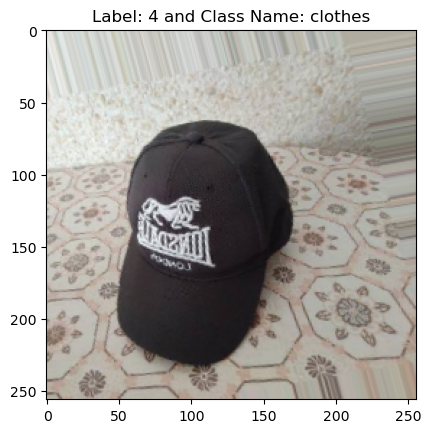

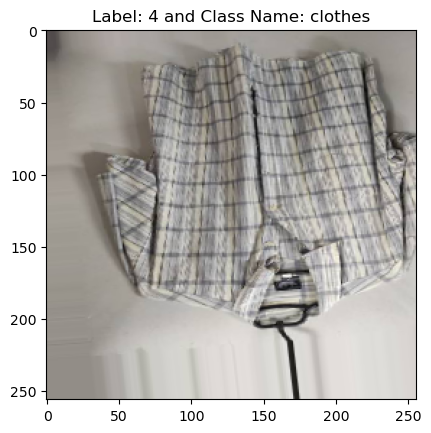

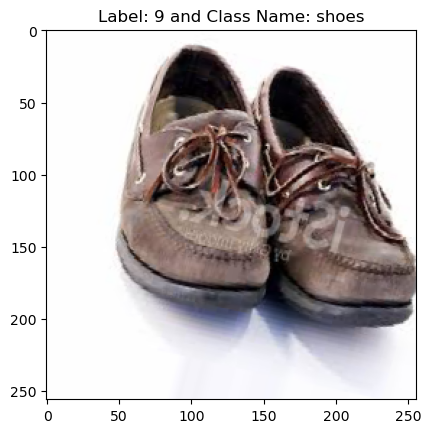

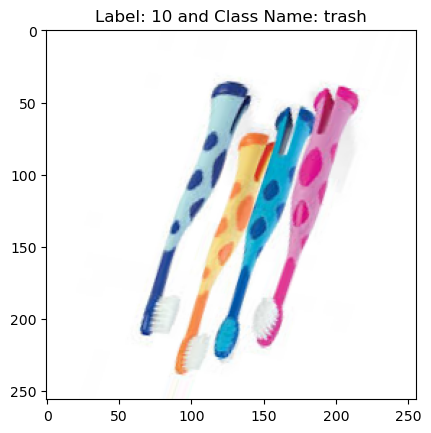

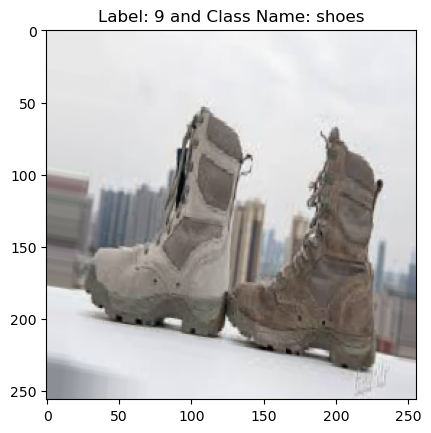

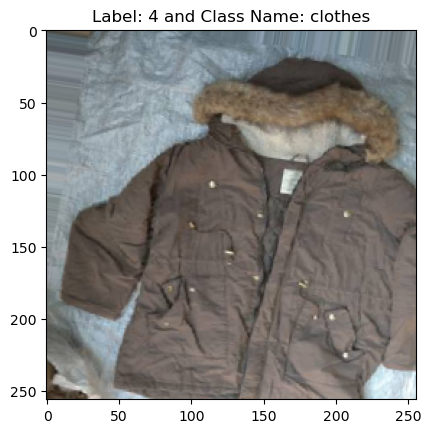

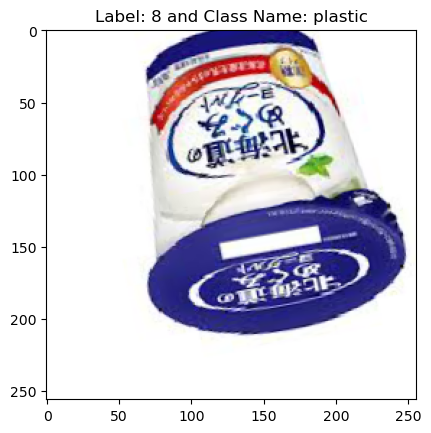

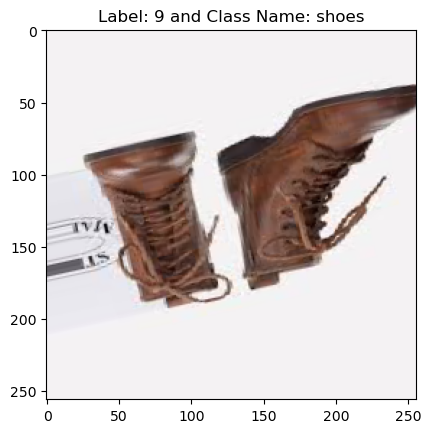

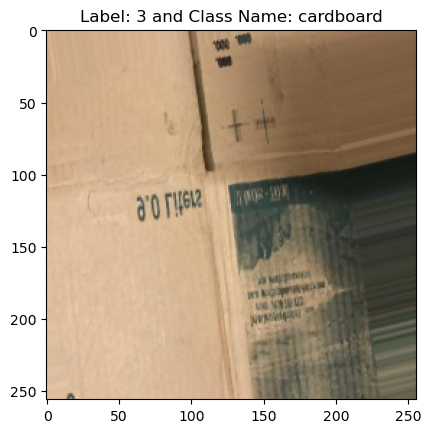

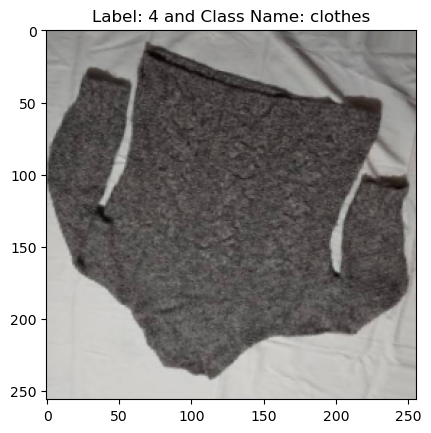

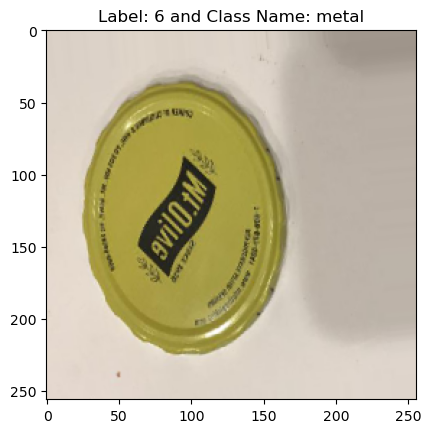

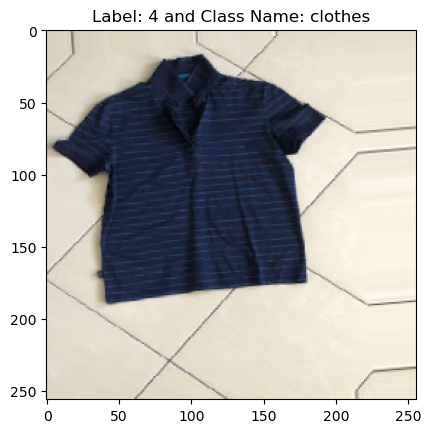

In [7]:
# Get a batch from the training generator
class_names = list(train_generator.class_indices.keys())
#print("Class Names:", class_names)
batch_images, batch_labels = next(train_generator)

# Visualize the first few images in the batch
num_images_to_visualize = 12
for i in range(num_images_to_visualize):
    # Get the image and label
    image = batch_images[i]
    label_index = np.argmax(batch_labels[i])
    class_name = class_names[label_index]
    
    # Plot the image
    plt.imshow(image)
    plt.title(f"Label: {label_index} and Class Name: {class_name}")
    plt.show()

***
# Implementing CNN - own build

In [8]:
# Check if a GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU found. Please make sure you have a GPU and TensorFlow is configured to use it.")

No GPU found. Please make sure you have a GPU and TensorFlow is configured to use it.


In [9]:
trainingsepochs = 50

***
## Calculate weights for unbalanced classes

In [10]:
from sklearn.utils.class_weight import compute_class_weight
# Klassen und ihre Frequenz
y_integers = np.array(train_generator.classes)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Umwandlung von Klassenindizes in ein Dictionary mit Klassennamen als Schlüssel
class_indices = train_generator.class_indices  # Sollte ein Dictionary sein: {'class1': 0, 'class2': 1, ...}
class_weights_dict
# Erstellen eines neuen Dictionaries, das Klassennamen den Gewichten zuordnet
class_weights_by_name = {class_name: class_weights_dict[class_index] for class_name, class_index in class_indices.items()}
class_weights_by_name

{'battery': 1.3681657848324515,
 'biological': 1.3126057529610828,
 'brown-glass': 2.131181318681319,
 'cardboard': 1.45,
 'clothes': 0.24280125195618155,
 'green-glass': 2.0576923076923075,
 'metal': 1.6827548806941433,
 'paper': 1.2313492063492064,
 'plastic': 1.4947013487475915,
 'shoes': 0.6540893760539629,
 'trash': 1.8514319809069213,
 'white-glass': 1.668279569892473}

In [11]:
from sklearn.utils import class_weight
num_classes = len(train_generator.class_indices)

## CNN2 - max pooling, relu, batch normalization, dropout, 

In [12]:
# Set the path for the model
model_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
model_filename = 'best_model_cnn2.keras'
checkpoint_path = os.path.join(model_path, model_filename)

# Check if the model exists
if os.path.exists(checkpoint_path):
    # Load the model
    model_cnn2 = load_model(checkpoint_path)
    print("Modell erfolgreich geladen.")
else:
    # Define the model
    model_cnn2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model_cnn2.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Display the model summary
    model_cnn2.summary()

    #checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
    #checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)
    
    # Define a callback to save the best model during training
    #checkpoint = ModelCheckpoint(os.path.join(model_path, 'best_model_cnn2.keras'), monitor='val_loss', save_best_only=True)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
    # Messung der Trainingszeit starten
    start_time_cnn2 = time.time()
    # Train the model
    history_cnn2 = model_cnn2.fit(
        train_generator,
        epochs=trainingsepochs,  # Adjust the number of epochs based on your needs
        validation_data=validation_generator,
        callbacks=[checkpoint],
        class_weight=class_weights_dict
    )

    # Messung der Trainingszeit beenden
    training_time_cnn2 = time.time() - start_time_cnn2
    print(f"Trainingszeit: {training_time_cnn2} Sekunden")

Modell erfolgreich geladen.


In [13]:
# Pfad und Dateiname für die Historie
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_cnn2 = 'best_model_cnn2_training_history.json'

# Rufe die Funktion auf, um die Trainingshistorie zu behandeln
save_history_to_json(history_cnn2 if 'history_cnn2' in locals() else None, history_filename_cnn2, history_path)


Training history file already exists at: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/best_model_cnn2_training_history.json.


In [14]:
check_compile(model_cnn2)

Alright. Model is already compiled and trained


In [15]:
with open(os.path.join(model_path, history_filename_cnn2), 'r') as file:
    loaded_history = json.load(file)   

## CNN3 - max pooling, stride 1,2 , padding = valid, relu

In [16]:
# Set the path for the model
model_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
model_filename = 'best_model_cnn3.keras'
checkpoint_path = os.path.join(model_path, model_filename)

# Check if the model exists
if os.path.exists(checkpoint_path):
    # Load the model
    model_cnn3 = load_model(checkpoint_path)
    print("Modell erfolgreich geladen.")
else:
    model_cnn3 = tf.keras.models.Sequential([
    Conv2D(32 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),

    Conv2D(64 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),
    
    Conv2D(64 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),
    
    Conv2D(128 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),
    
    Flatten(),
    Dense(units = 128 , activation = 'relu'),
    Dropout(0.2),
    Dense(units = num_classes, activation='softmax')  # Adjust 'num_classes' based on your task
])

    # Compile the model
    model_cnn3.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Display the model summary
    model_cnn3.summary()

    #checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
    #checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)
    
    # Define a callback to save the best model during training
    #checkpoint = ModelCheckpoint(os.path.join(model_path, 'best_model_cnn2.keras'), monitor='val_loss', save_best_only=True)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

    start_time_cnn3 = time.time()
    # Train the model
    
    # Train the model
    history_cnn3 = model_cnn3.fit(
        train_generator,
        epochs=trainingsepochs,  # Adjust the number of epochs based on your needs
        validation_data=validation_generator,
        callbacks=[checkpoint],
        class_weight=class_weights_dict
    )

    # Messung der Trainingszeit beenden
    training_time_cnn3 = time.time() - start_time_cnn3
    print(f"Trainingszeit: {training_time_cnn3} Sekunden")

Modell erfolgreich geladen.


In [17]:
check_compile(model_cnn3)

Alright. Model is already compiled and trained


In [18]:
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_cnn3 = 'best_model_cnn3_training_history.json'

# Speichern der Historie
# Rufe die Funktion auf, um die Trainingshistorie zu behandeln
save_history_to_json(history_cnn3 if 'history_cnn3' in locals() else None, history_filename_cnn3, history_path)

Training history file already exists at: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/best_model_cnn3_training_history.json.


In [19]:
# Speichern der Daten in einer JSON-Datei
with open(os.path.join(model_path, history_filename_cnn3), 'r') as file:
    loaded_history = json.load(file)

***
## Hyperparameter Tuning Model

In [20]:
trainingsepochs_hp=25

In [21]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from kerastuner.tuners import BayesianOptimization
import numpy as np
import os
import json

In [22]:
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers.legacy import Adam

def build_model(hp):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Tuning the number and size of convolutional layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv2D(hp.Int(f'filters_{i}', 32, 128, 32), (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    
    # Tuning the number and size of dense layers
    for i in range(hp.Int('num_dense_layers', 1, 2)):
        model.add(Dense(hp.Int(f'units_{i}', 128, 512, 128), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, 0.1)))
        # Adding L1/L2 regularization
        model.add(Dense(units=hp.Int(f'units_{i}', 128, 512, 128), 
                        activation='relu', 
                        kernel_regularizer=l1_l2(l1=hp.Float('l1', 1e-5, 1e-2, sampling='LOG', default=1e-5), 
                                                 l2=hp.Float('l2', 1e-5, 1e-2, sampling='LOG', default=1e-4))))

    model.add(Dense(num_classes, activation='softmax'))

    # Tuning the learning rate
    hp_lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

    model.compile(optimizer=Adam(learning_rate=hp_lr), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [23]:
#Pfad zum Tuner-Verzeichnis und zum Modell
tuner_dir = 'bayesian_optimization/garbage_classification'
model_path = 'best_models/hyperparameter_model.keras'
history_path = 'best_models'  # Verzeichnis, in dem die Historie gespeichert wird
history_filename_hp = 'best_model_hp_model_training_history.json'

# Überprüfen, ob das beste Modell bereits existiert
if os.path.exists(model_path):
    print("Bestes Modell wird geladen...")
    hyperparameter_model = load_model(model_path)
    print("Bestes Modell erfolgreich geladen.")
else:
    print("Kein vortrainiertes Modell gefunden. Starte den Hyperparameter-Tuning-Prozess.")
    tuner = BayesianOptimization(
        build_model,
        objective='val_accuracy',
        max_trials=5,
        num_initial_points=4,
        directory=tuner_dir,
        project_name='garbage_classification'
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    start_time_hp = time.time()

    tuner.search(train_generator,
                 epochs=trainingsepochs_hp,
                 validation_data=validation_generator,
                 callbacks=[early_stopping],
                 class_weight=class_weights_dict)

    training_time_hp = time.time() - start_time_hp
    print(f"Trainingszeit: {training_time_hp} Sekunden")

    # Hole das beste Modell
    best_model = tuner.get_best_models(num_models=1)[0]

    # Speichere das beste Modell
    print("Speichere das beste Modell...")
    best_model.save(model_path)
    print(f"Bestes Modell gespeichert unter: {model_path}")

    # Extrahiere und speichere die Trainingshistorie des besten Trials
    best_trial_id = tuner.oracle.get_best_trials(num_trials=1)[0].trial_id
    best_trial_history = tuner.get_best_trial(best_trial_id).metrics.get_history()
    best_trial_metrics = {metric: [entry['value'] for entry in best_trial_history[metric]] for metric in best_trial_history}

    # Speichere die Trainingshistorie mit Ihrer Funktion
    save_history_to_json(best_trial_metrics, history_filename_hp, history_path)

Bestes Modell wird geladen...
Bestes Modell erfolgreich geladen.


In [24]:
hyperparameter_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 96)      27744     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 96)      384       
 chNormalization)                                                
                                                        

In [25]:
loss, accuracy = hyperparameter_model.evaluate(validation_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}")

97/97 [==============================] - 22s 222ms/step - loss: 1.2111 - accuracy: 0.7809
Loss: 1.2110644578933716, Accuracy: 0.7808572053909302


In [26]:
# Speichern der Trainingshistorie
history_filename_hp = 'best_model_hp_model_training_history.json'


save_history_to_json(history_hp if 'history_hp' in locals() else None, history_filename_hp, history_path)

No training history to save, and no existing history file found.


In [27]:
#with open(os.path.join(model_path, history_filename_hp), 'r') as file:
#    loaded_history = json.load(file)

***
# Implementing Pre-Trained Models


In [28]:
trainingsepochs = 20

## Transfer Learning of VGG16

In [29]:
# Set the path for the model
model_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
model_filename_vgg16_tl = 'best_model_vgg16_tl.keras'  # Update this to your VGG16 model filename
checkpoint_path_vgg16_tl = os.path.join(model_path, model_filename_vgg16_tl)

# Check if the model exists
if os.path.exists(checkpoint_path_vgg16_tl):
    # Load the model
    model_VGG16_transfer = load_model(checkpoint_path_vgg16_tl)
    print("VGG16 transfer model successfully loaded.")
else:
    print("VGG16 transfer model not found, starting training.")
    # Load pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model and add pre-trained layers
    model_VGG16_transfer = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')  # Replace num_classes with the actual number of classes
    ])

    # Compile the model
    model_VGG16_transfer.compile(optimizer=Adam(), #tf.keras.optimizers.legacy.Adam()
                                 loss='categorical_crossentropy', metrics=['accuracy'])

    # Display the model summary
    model_VGG16_transfer.summary()

    # Define a callback to save the best model during training
    checkpoint = ModelCheckpoint(checkpoint_path_vgg16_tl, monitor='val_loss', save_best_only=True)

    start_time_VGG16_transfer = time.time()
    
    # Train the model
    history_VGG16_transfer = model_VGG16_transfer.fit(
        train_generator,
        epochs=trainingsepochs,  # Adjust the number of epochs based on your needs
        validation_data=validation_generator,
        callbacks=[checkpoint],
        workers=6,
        class_weight=class_weights_dict
    )

    # Messung der Trainingszeit beenden
    training_time_VGG16_transfer = time.time() - start_time_VGG16_transfer
    print(f"Trainingszeit: {training_time_VGG16_transfer} Sekunden")

VGG16 transfer model successfully loaded.


In [30]:
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_VGG16tl = 'VGG16_transfer_model_training_history.json'

# Speichern der Historie
save_history_to_json(history_VGG16_transfer if 'history_VGG16_transfer' in locals() else None, history_filename_VGG16tl, history_path)

Training history file already exists at: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/VGG16_transfer_model_training_history.json.


In [31]:
with open(os.path.join(model_path, history_filename_VGG16tl), 'r') as file:
    loaded_history = json.load(file)

***
## Fine Tuning of VGG16

In [32]:
#Fine Tuning
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
import tensorflow as tf

# Set the path for the model
model_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
model_filename_ft = 'best_model_vgg16_ft.keras'
checkpoint_path_ft = os.path.join(model_path, model_filename_ft)

# Check if the model exists
if os.path.exists(checkpoint_path_ft):
    # Load the model
    vgg16_ft = load_model(checkpoint_path_ft)
    print("Modell erfolgreich geladen.")
else:
    print("Modell wird neu trainiert.")
    
    # 1. Laden des vortrainierten VGG16-Modells
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    
    # 2. Anpassen des Models an meine Daten
    vgg16_ft = models.Sequential()
    vgg16_ft.add(base_model)  # Hinzufügen des vortrainierten Modells als Basis
    vgg16_ft.add(layers.Flatten())
    
    # Hinzufügen einiger Fully-Connected Schichten
    vgg16_ft.add(layers.Dense(256, activation='relu'))
    vgg16_ft.add(layers.Dropout(0.5))
    vgg16_ft.add(layers.Dense(num_classes, activation='softmax')) 
    
    # 3. Einfrieren aller Schichten im Basis-Modell
    base_model.trainable = False
    
    # 4. Kompilieren und Trainieren des Models
    vgg16_ft.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define a callback to save the best model during training
    checkpoint = ModelCheckpoint(checkpoint_path_ft, 
                                 monitor='val_loss', 
                                 save_best_only=True)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    
    # Trainieren des Modells mit Ihren eigenen `train_generator` und `validation_generator`
    history_initial = vgg16_ft.fit(train_generator, 
                                   validation_data=validation_generator, 
                                   epochs=trainingsepochs, 
                                   callbacks=[checkpoint])
    
    # 5. Fine-Tuning einiger Schichten des Basis-Modells
    # Auftauen der oberen Schichten des VGG16-Modells
    base_model.trainable = True
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Kompilieren des Modells mit einer niedrigeren Lernrate
    vgg16_ft.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),  #tf.keras.optimizers.legacy.Adam
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

    start_time_VGG16_ft = time.time()

    
    # Erneutes Trainieren des Modells mit Fine-Tuning
    history_fine_tuning = vgg16_ft.fit(train_generator, 
                                       validation_data=validation_generator, 
                                       epochs=trainingsepochs, 
                                       callbacks=[checkpoint, early_stopping],
                                       workers=6,
                                       class_weight=class_weights_dict)
    # Messung der Trainingszeit beenden
    training_time_VGG16_ft = time.time() - start_time_VGG16_ft
    print(f"Trainingszeit: {training_time_VGG16_ft} Sekunden")



Modell erfolgreich geladen.


In [33]:
# Display the model summary
vgg16_ft.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 12)                3084      
                                                                 
Total params: 23106636 (88.14 MB)
Trainable params: 15471372 (59.02 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [34]:
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_VGG16ft = 'VGG16_finetuning_model_training_history.json'

# Speichern der Historie
save_history_to_json(history_fine_tuning if 'history_fine_tuning' in locals() else None, history_filename_VGG16ft, history_path)

Training history file already exists at: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/VGG16_finetuning_model_training_history.json.


***
## RESNET 

In [35]:
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Set the path for the model
model_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
model_filename_resnet = 'best_model_resnet.keras'
checkpoint_path_resnet = os.path.join(model_path, model_filename_resnet)

# Check if the model exists
if os.path.exists(checkpoint_path_resnet):
    # Load the model
    model_resnet = load_model(checkpoint_path_resnet)
    print("ResNet model successfully loaded.")
else:
    print("ResNet model not found, starting training.")
    # Load pre-trained ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    # Freeze the layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model and add pre-trained layers
    model_resnet = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Replace num_classes with the actual number of classes
    ])

    # Compile the model
    model_resnet.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Display the model summary
    model_resnet.summary()

    # Define a callback to save the best model during training
    checkpoint = ModelCheckpoint(checkpoint_path_resnet, monitor='val_loss', save_best_only=True)

    start_time_resnet = time.time()
    
    # Train the model
    history_resnet = model_resnet.fit(
        train_generator,
        epochs=trainingsepochs,  # Adjust the number of epochs based on your needs
        validation_data=validation_generator,
        callbacks=[checkpoint],
        workers=6,
        class_weight=class_weights_dict
    )

    # Messung der Trainingszeit beenden
    training_time_resnet = time.time() - start_time_resnet
    print(f"Trainingszeit: {training_time_resnet} Sekunden")


ResNet model successfully loaded.


In [36]:
history_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/'
history_filename_resnet = 'resnet_training_history.json'  # Aktualisierter Dateiname für ResNet

# Speichern der Historie
save_history_to_json(history_resnet if 'history_resnet' in locals() else None, history_filename_resnet, history_path)


Training history file already exists at: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Best_Models/resnet_training_history.json.


***
# Evaluation Protocoll


In [37]:
epochs_cross_validations=10
number_splits = 10

***
### Evalutation Protocoll: K-Fold Cross Validation for CNN2

In [38]:
default_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Cross_Validation_Results/'
results_file_cnn2 = 'cnn2_model_cross_validation_results.json'
results_path_cnn2 = os.path.join(default_path, results_file_cnn2)

if os.path.exists(results_path_cnn2):
    print(f"Ergebnisse der Kreuzvalidierung für das CNN2-Modell existieren bereits unter: {results_path_cnn2}")
    results_cnn2 = load_results_from_json(results_file_cnn2)
else:
    # Hier fügst du den Code für die Kreuzvalidierung des model_cnn2 ein
    fold_performance_model_cnn2, avg_perf_model_cnn2, fold_histories_model_cnn2 = k_fold_cross_validation(model_cnn2, 
                                                                                                      train_cross_validation_generator, 
                                                                                                      n_splits=number_splits, 
                                                                                                      epochs=epochs_cross_validations)
        # Convert NumPy arrays in histories to lists
    fold_histories_lists_model2 = [
        {key: np.array(val).tolist() for key, val in fold_history.items()} 
        for fold_history in fold_histories_model_cnn2  # use the correct variable here
    ]
    
    results_model2  = {
        "fold_performance": fold_performance_model_cnn2,
        "average_performance": avg_perf_model_cnn2,
        "fold_histories": fold_histories_lists_model2
    }
    
    # Speichern der Ergebnisse
    save_results_to_json(results_file_cnn2, results_model2)
    

#fange mit 20 Epochen an und gehe dann hoch auf +50

Ergebnisse der Kreuzvalidierung für das CNN2-Modell existieren bereits unter: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Cross_Validation_Results/cnn2_model_cross_validation_results.json


***
### Evalutation Protocoll: K-Fold Cross Validation for CNN3

In [39]:
results_file_cnn3 = 'cnn3_model_cross_validation_results.json'
results_path_cnn3 = os.path.join(default_path, results_file_cnn3)

if os.path.exists(results_path_cnn3):
    print(f"Ergebnisse der Kreuzvalidierung für das CNN3-Modell existieren bereits unter: {results_path_cnn3}")
    results_cnn3 = load_results_from_json(results_file_cnn3)
else:
    fold_performance_model_cnn3, avg_perf_model_cnn3, fold_histories_model_cnn3 = k_fold_cross_validation(model_cnn3, 
                                                                                                      train_cross_validation_generator, 
                                                                                                      n_splits=number_splits, 
                                                                                                      epochs=epochs_cross_validations)
    fold_histories_lists_model3 = [
        {key: np.array(val).tolist() for key, val in fold_history.items()} 
        for fold_history in fold_histories_model_cnn3
    ]
    
    results_model3 = {
        "fold_performance": fold_performance_model_cnn3,
        "average_performance": avg_perf_model_cnn3,
        "fold_histories": fold_histories_lists_model3
    }
    
    save_results_to_json(results_file_cnn3, results_model3)


Ergebnisse der Kreuzvalidierung für das CNN3-Modell existieren bereits unter: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Cross_Validation_Results/cnn3_model_cross_validation_results.json


***
### Evalutation Protocoll: K-Fold Cross Validation for Hyperparameter Tuning Model

In [40]:
results_file_hyperparameter = 'hyperparameter_model_cross_validation_results.json'
results_path_hyperparameter = os.path.join(default_path, results_file_hyperparameter)

if os.path.exists(results_path_hyperparameter):
    print(f"Ergebnisse der Kreuzvalidierung für das Hyperparameter-Modell existieren bereits unter: {results_path_hyperparameter}")
    results_hyperparameter = load_results_from_json(results_file_hyperparameter)
else:
    fold_performance_hyperparameter_model, avg_perf_hyperparameter_model, fold_histories_hyperparameter_model = k_fold_cross_validation(
        hyperparameter_model, 
        train_cross_validation_generator, 
        n_splits=number_splits, 
        epochs=epochs_cross_validations
    )
    
    # Convert NumPy arrays in histories to lists for JSON serialization
    fold_histories_lists_hyperparameter = [
        {key: np.array(val).tolist() for key, val in fold_history.items()} 
        for fold_history in fold_histories_hyperparameter_model
    ]
    
    results_hyperparameter = {
        "fold_performance": fold_performance_hyperparameter_model,
        "average_performance": avg_perf_hyperparameter_model,
        "fold_histories": fold_histories_lists_hyperparameter
    }
    
    # Speichern der Ergebnisse
    save_results_to_json(results_file_hyperparameter, results_hyperparameter)


Ergebnisse der Kreuzvalidierung für das Hyperparameter-Modell existieren bereits unter: /Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/Cross_Validation_Results/hyperparameter_model_cross_validation_results.json


***
### Evalutation Protocoll: K-Fold Cross Validation for VGG16 Transfer Learning Model

In [ ]:
results_file_vgg16_transfer = 'vgg16_transfer_model_cross_validation_results.json'
results_path_vgg16_transfer = os.path.join(default_path, results_file_vgg16_transfer)

if os.path.exists(results_path_vgg16_transfer):
    print(f"Ergebnisse der Kreuzvalidierung für das VGG16-Transfer-Modell existieren bereits unter: {results_path_vgg16_transfer}")
    results_vgg16_transfer = load_results_from_json(results_file_vgg16_transfer)
else:
    fold_performance_vgg16_transfer, avg_perf_vgg16_transfer, fold_histories_vgg16_transfer = k_fold_cross_validation(
        model_VGG16_transfer, 
        train_cross_validation_generator, 
        n_splits=number_splits, 
        epochs=epochs_cross_validations
    )
    
    # Convert NumPy arrays in histories to lists for JSON serialization
    fold_histories_lists_vgg16_transfer = [
        {key: np.array(val).tolist() for key, val in fold_history.items()} 
        for fold_history in fold_histories_vgg16_transfer
    ]
    
    results_vgg16_transfer = {
        "fold_performance": fold_performance_vgg16_transfer,
        "average_performance": avg_perf_vgg16_transfer,
        "fold_histories": fold_histories_lists_vgg16_transfer
    }
    
    # Speichern der Ergebnisse
    save_results_to_json(results_file_vgg16_transfer, results_vgg16_transfer)


Found 2700 validated image filenames belonging to 12 classes.
Found 300 validated image filenames belonging to 12 classes.
Epoch 1/10
49/84 [================>.............] - ETA: 2:19 - loss: 2.2720 - accuracy: 0.3367

***
### Evalutation Protocoll: K-Fold Cross Validation for VGG16 Fine Tuning Model

In [ ]:
results_file_vgg16_ft = 'vgg16_ft_model_cross_validation_results.json'
results_path_vgg16_ft = os.path.join(default_path, results_file_vgg16_ft)

if os.path.exists(results_path_vgg16_ft):
    print(f"Ergebnisse der Kreuzvalidierung für das VGG16-Fine-Tuning-Modell existieren bereits unter: {results_path_vgg16_ft}")
    results_vgg16_ft = load_results_from_json(results_file_vgg16_ft)
else:
    fold_performance_vgg16_ft, avg_perf_vgg16_ft, fold_histories_vgg16_ft = k_fold_cross_validation(
        vgg16_ft, 
        train_cross_validation_generator, 
        n_splits=number_splits, 
        epochs=epochs_cross_validations
    )
    
    # Convert NumPy arrays in histories to lists for JSON serialization
    fold_histories_lists_vgg16_ft = [
        {key: np.array(val).tolist() for key, val in fold_history.items()} 
        for fold_history in fold_histories_vgg16_ft
    ]
    
    results_vgg16_ft = {
        "fold_performance": fold_performance_vgg16_ft,
        "average_performance": avg_perf_vgg16_ft,
        "fold_histories": fold_histories_lists_vgg16_ft
    }
    
    # Speichern der Ergebnisse
    save_results_to_json(results_file_vgg16_ft, results_vgg16_ft)


***
### Evalutation Protocoll: K-Fold Cross Validation for ResNet Model

In [ ]:
results_file_resnet = 'resnet_model_cross_validation_results.json'
results_path_resnet = os.path.join(default_path, results_file_resnet)

if os.path.exists(results_path_resnet):
    print(f"Ergebnisse der Kreuzvalidierung für das ResNet-Modell existieren bereits unter: {results_path_resnet}")
    results_resnet = load_results_from_json(results_file_resnet)
else:
    fold_performance_resnet, avg_perf_resnet, fold_histories_resnet = k_fold_cross_validation(
        model_resnet, 
        train_cross_validation_generator, 
        n_splits=number_splits, 
        epochs=epochs_cross_validations
    )
    
    # Convert NumPy arrays in histories to lists for JSON serialization
    fold_histories_lists_resnet = [
        {key: np.array(val).tolist() for key, val in fold_history.items()} 
        for fold_history in fold_histories_resnet
    ]
    
    results_resnet = {
        "fold_performance": fold_performance_resnet,
        "average_performance": avg_perf_resnet,
        "fold_histories": fold_histories_lists_resnet
    }
    
    # Speichern der Ergebnisse
    save_results_to_json(results_file_resnet, results_resnet)


***

# Hypothesis tests for model comparisons

In [ ]:
models = [model_cnn2, model_cnn3, hyperparameter_model, model_VGG16_transfer, vgg16_ft, model_resnet]
model_names = ['model_cnn2', 'model_cnn3', 
               "hyperparameter_model", 
               "model_VGG16_transfer",
              "model_vgg16_ft", 
              "model_resnet"]

#training_times = [training_time_cnn2, training_time_cnn3, training_time_hp,training_time_VGG16_transfer,training_time_VGG16_ft, training_time_resnet]


results_model2 = load_results_from_json("cnn2_model_cross_validation_results.json", default_path)
results_model3 = load_results_from_json("cnn3_model_cross_validation_results.json", default_path)
results_hyperparameter_model = load_results_from_json("hyperparameter_model_cross_validation_results.json", default_path)

results_resnet = load_results_from_json("resnet_model_cross_validation_results.json", default_path)
results_vgg16_ft = load_results_from_json("vgg16_ft_model_cross_validation_results.json", default_path)
results_vgg16_transfer = load_results_from_json("vgg16_transfer_model_cross_validation_results.json", default_path)


accuracies_model2 = results_model2['fold_performance']
accuracies_model3 = results_model3['fold_performance']
accuracies_hyperparameter_model = results_hyperparameter_model['fold_performance']

accuracies_resnet = results_resnet['fold_performance']
accuracies_vgg16_ft = results_vgg16_ft['fold_performance']
accuracies_vgg16_transfer = results_vgg16_transfer['fold_performance']


# Speichere die Genauigkeiten aller Modelle in einem Dictionary für einen leichteren Zugriff
model_accuracies = {
    'Model2': results_model2['fold_performance'],
    'Model3': results_model3['fold_performance'],
    'Hyperparameter': results_hyperparameter_model['fold_performance'],
    'ResNet': results_resnet['fold_performance'],
    'VGG16_FT': results_vgg16_ft['fold_performance'],
    'VGG16_Transfer': results_vgg16_transfer['fold_performance']
}

## Better as Random Chance??

In [ ]:
import numpy as np
from scipy.stats import binom
from sklearn.metrics import accuracy_score
import pandas as pd
from tensorflow.keras.models import load_model

# Ihre Funktion zur Berechnung des Konfidenzintervalls bleibt unverändert
def calculate_accuracy_confidence_interval(model, test_generator, confidence_level=0.95):
    true_labels = []
    predictions = []

    for i in range(len(test_generator)):
        X, y = test_generator[i]
        true_labels.extend(np.argmax(y, axis=1))
        preds = model.predict(X, verbose=0)
        predictions.extend(np.argmax(preds, axis=1))

    observed_accuracy = accuracy_score(true_labels, predictions)
    n_successes = observed_accuracy * len(true_labels)
    n_trials = len(true_labels)

    confidence_interval = binom.interval(confidence_level, n_trials, observed_accuracy, loc=0)
    confidence_interval_accuracy = (confidence_interval[0] / n_trials, confidence_interval[1] / n_trials)

    return confidence_interval_accuracy

In [ ]:
# Liste für Konfidenzintervalle
confidence_intervals = []

# Berechnen Sie das Konfidenzintervall für jedes Modell und speichern Sie die Ergebnisse
for model in models:
    ci = calculate_accuracy_confidence_interval(model, test_generator, confidence_level=0.95)
    confidence_intervals.append(ci)

# Erstellen Sie ein DataFrame mit den Ergebnissen
results_df = pd.DataFrame({
    'Modell': model_names,
    'Konfidenzintervall Untergrenze': [ci[0] for ci in confidence_intervals],
    'Konfidenzintervall Obergrenze': [ci[1] for ci in confidence_intervals]
})



In [ ]:
results_df

## Sign Test for K-Fold Cross Validation

In [ ]:
# Führe den Sign-Test aus
p_value, reject_null, better_alg = sign_test(accuracies_model2, accuracies_model3, alpha=0.05)

print(f"P-Wert: {p_value}")
print(f"Nullhypothese ablehnen: {'Ja' if reject_null else 'Nein'}")
print(f"Besserer Algorithmus: {better_alg}")

In [ ]:
# Speichere die Genauigkeiten aller Modelle in einem Dictionary für einen leichteren Zugriff
model_accuracies = {
    'Model2': accuracies_model2,
    'Model3': accuracies_model3,
    'Hyperparameter': accuracies_hyperparameter_model,
    'ResNet': accuracies_resnet,
    'VGG16_FT': accuracies_vgg16_ft,
    'VGG16_Transfer': accuracies_vgg16_transfer
}

# Erstelle eine Liste für die P-Werte und Entscheidungen
sign_test_results = []

# Vergleiche jedes Modell mit jedem anderen Modell
for (model1, acc1), (model2, acc2) in combinations(model_accuracies.items(), 2):
    p_value, reject_null, better_alg = sign_test_table(model1, acc1, model2, acc2)
    # Rest des Codes...
    sign_test_results.append({
        'Model1': model1,
        'Model2': model2,
        'P_Value': p_value,
        'Reject_Null': reject_null,
        'Better_Model': better_alg if reject_null else 'No significant difference',
        'Better_Model_Ignoring_Significance': better_alg
    })

# Zähle die Gewinne für jedes Modell, wenn es einen signifikanten Unterschied gibt
wins_count_significant = {model: 0 for model in model_accuracies.keys()}
wins_count_total = {model: 0 for model in model_accuracies.keys()}

for result in sign_test_results:
    if result['Reject_Null']:
        wins_count_significant[result['Better_Model']] += 1
    # Zähle hier die Gewinne, ohne die Signifikanz zu berücksichtigen
    if result['Better_Model_Ignoring_Significance'] and result['Better_Model_Ignoring_Significance'] != 'No significant difference':
        wins_count_total[result['Better_Model_Ignoring_Significance']] += 1
        
# Jetzt erstellen wir zwei getrennte Ranglisten:
# Eine für signifikante Gewinne und eine für die Gesamtanzahl der Gewinne
ranking_significant = pd.DataFrame(list(wins_count_significant.items()), columns=['Model', 'Wins_Significant']).sort_values('Wins_Significant', ascending=False)
ranking_significant['Rank_Significant'] = ranking_significant['Wins_Significant'].rank(ascending=False, method='dense')

ranking_total = pd.DataFrame(list(wins_count_total.items()), columns=['Model', 'Wins_Total']).sort_values('Wins_Total', ascending=False)
ranking_total['Rank_Total'] = ranking_total['Wins_Total'].rank(ascending=False, method='dense')

# Erstelle das Ergebnis-DataFrame
df_results = pd.DataFrame(sign_test_results)

# Füge die Ranglisten in das Ergebnis-DataFrame ein
df_final = pd.merge(df_results, ranking_significant, left_on='Model1', right_on='Model', how='left')
df_final = pd.merge(df_final, ranking_total, left_on='Model1', right_on='Model', how='left')

# Wähle die relevanten Spalten aus und sortiere nach den signifikanten Rängen
df_final = df_final[['Model1', 'Model2', 'P_Value', 'Reject_Null', 'Better_Model', 'Wins_Significant', 'Rank_Significant', 'Wins_Total', 'Rank_Total']]
df_final_sorted = df_final.sort_values(by='Rank_Significant', ascending=True)

# Erstelle die aggregierte Tabelle für signifikante Gewinne
ranking_significant = pd.DataFrame(list(wins_count_significant.items()), columns=['Model', 'Wins_Significant'])
ranking_significant['Rank_Significant'] = ranking_significant['Wins_Significant'].rank(ascending=False, method='dense')

# Erstelle die aggregierte Tabelle für die Gesamtanzahl der Gewinne
ranking_total = pd.DataFrame(list(wins_count_total.items()), columns=['Model', 'Wins_Total'])
ranking_total['Rank_Total'] = ranking_total['Wins_Total'].rank(ascending=False, method='dense')

# Zusammenführen der beiden aggregierten Tabellen in eine
df_aggregated_results = pd.merge(ranking_significant, ranking_total, on='Model')
df_detailed_results = pd.DataFrame(sign_test_results)


In [ ]:
df_detailed_results

In [ ]:
df_aggregated_results.sort_values(by='Rank_Total')

## T-test of Cross-Validations Fold Accuraccy

In [ ]:
perform_and_compare_t_test(results_model2['fold_performance'],results_model3['fold_performance'])

## Evaluation on Unseen Test Set

In [ ]:
len(test_generator)

In [ ]:
test_generator

In [ ]:
df_test

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import time

# Definieren Sie Ihre Modelle und deren Namen
models = [model_cnn2, model_cnn3, hyperparameter_model, model_VGG16_transfer, vgg16_ft, model_resnet]
model_names = ['model_cnn2', 'model_cnn3', "hyperparameter_model", "model_VGG16_transfer", "vgg16_ft", "model_resnet"]

# Listen für die Speicherung der Ergebnisse
results = []

# Stellen Sie sicher, dass der Testgenerator zurückgesetzt wird
test_generator.reset()

# Iterieren Sie über jedes Modell, um Vorhersagen zu machen und Metriken zu berechnen
for model, name in zip(models, model_names):
    start_time = time.time()  # Startzeit der Vorhersage
    true_labels, predictions, probabilities = [], [], []

    # Durchlaufen Sie den Testgenerator, ohne tqdm zu verwenden
    for i in range(len(test_generator)):
        X, y = test_generator[i]
        y_true = np.argmax(y, axis=1)
        y_pred = model.predict(X)
        y_pred_classes = np.argmax(y_pred, axis=1)
        probabilities.extend(y_pred)  # Für ROC-AUC Berechnung
        true_labels.extend(y_true)
        predictions.extend(y_pred_classes)

    # Vorhersagezeit berechnen
    prediction_time = time.time() - start_time
    total_params = model.count_params()  # Gesamtanzahl der Parameter im Modell

    # Metriken berechnen
    accuracy = accuracy_score(true_labels, predictions)
    auc_score = roc_auc_score(true_labels, probabilities, multi_class='ovr', average='macro')
    precision = precision_score(true_labels, predictions, average='macro',  zero_division=1)
    recall = recall_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')

    # Ergebnisse speichern
    results.append({
        'Modell': name,
        'Accuracy': accuracy,
        'AUC': auc_score,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Vorhersagezeit (Sekunden)': prediction_time,
        'Gesamtanzahl Parameter': total_params
    })

# Ergebnisse in einem DataFrame zusammenfassen
results_df = pd.DataFrame(results)



In [ ]:
results_df

# Discussion and Conclusion

## Websites where i have to look in 

* https://www.jeremyjordan.me/convnet-architectures/
* https://github.com/pedropro/TACO
* https://github.com/AgaMiko/waste-datasets-review/tree/main/img
* https://github.com/settings/copilot

Certainly! In addition to hypothesis testing, there are several other aspects you might want to check to ensure a comprehensive evaluation of your classification model. Here are some key considerations:

1. Confusion Matrix and Classification Report:
    * Analyze the confusion matrix to understand how well your model is performing for each class. It provides insights into true positives, true negatives, false positives, and false negatives.
    * Use the classification report to obtain precision, recall, and F1-score for each class.
2. ROC Curve and AUC:
    * If your problem is binary classification, consider plotting the ROC curve and calculating the Area Under the Curve (AUC) to assess the model's ability to discriminate between classes.
3. Cross-Validation:
    * Implement k-fold cross-validation to evaluate the model's performance on multiple train-test splits. This helps assess the model's generalization across different subsets of the data.
4. Learning Curves:
    * Plot learning curves to visualize the model's training and validation performance over epochs. This helps identify overfitting or underfitting issues.
5. Feature Importance:
    * If applicable, investigate feature importance. In image classification, this might not be as straightforward, but if you have extracted features from the images or are using a graph-based model, consider analyzing feature importance.
6. Model Interpretability:
    * Utilize techniques for model interpretability, such as SHAP (SHapley Additive exPlanations) values or LIME (Local Interpretable Model-agnostic Explanations), to understand the model's decision-making process.
7. Hyperparameter Tuning:
    * Experiment with different hyperparameter settings to optimize model performance. This could include learning rate, batch size, number of layers, etc.
8. Handling Class Imbalance:
    * If your dataset has imbalanced classes, explore techniques such as oversampling, undersampling, or using class weights to address the imbalance.
9. Error Analysis:
    * Analyze specific examples where the model fails to make accurate predictions. Understanding the types of errors can provide insights into potential improvements.
10. Deployment Considerations:
    * If you plan to deploy the model, consider additional factors such as model size, computational efficiency, and inference speed.
    * Remember that the evaluation process is an iterative one, and it's essential to tailor it to the specifics of your project and dataset. Adjust your evaluation strategy based on the insights gained from each step to iteratively improve your model.